In [12]:
import numpy as np
import matplotlib.pyplot as plt


def getBinomial(
        k):  # A function that takes an index k and returns i,j such that i+j = 2k and are binomially distributed with probability 0.5
    i = int(np.random.binomial(2 * k, 0.5))  #Calculates i
    j = (2 * k) - i  #j = 2k - i
    return i, j

In [13]:
def GillespieSSA_1():
    stateVector = np.zeros(
        200)  # A vector to hold the number of particles in each state, we assume that a particle in state 201 or larger will not be generated in such a short timeframe
    binnedData = np.zeros(
        (1002,
         200))  # This keeps track of the state vectors at discretised bins of time (width 0.01 time units => 1000 bins total) alongside initial and final states.
    stateVector[1] = 1  #Initialises state vector with one cell with 1ecDNA copy
    binnedData[0] = stateVector  #Appends the inital state to the output data structure
    t = 0  # A count for the time value
    N = 1  # A count for the total number of particles, note when a reaction occurs. One new particle is created

    while t < 10:  # iterate the algorithm for 10 time units
        r1 = np.random.random()  # generate 2 uniformly random numbers in the interval (0,1), r1 and r2
        r2 = np.random.random()
        tau = np.log(1 / r1) / N  # determines time until next reaction
        k = 0

        tempSum = 0  # temporary value used to find k satisfying 4d in Gillspie SSA in lecture notes
        # This for loop find the reaction to occur at time: t + tau
        checkValue = N * r2  # defined to reduce number of calculations performed
        for k, Nk in enumerate(stateVector):  #iterating over states to find the reaction k to occur
            if (tempSum <= checkValue) and (checkValue < (tempSum + Nk)):  # checks to see if reaction k occurs
                break
            else:
                tempSum += Nk

        i, j = getBinomial(k)  # obtains i,j according to binomial distribution
        # update stateVector

        stateVector[k] -= 1
        stateVector[i] += 1
        stateVector[j] += 1

        # update t, N, and binnedData
        t += tau
        N += 1
        bin = int(np.floor(100 * t)) + 1  # determines which bin to place stateVector in
        if bin <= 1000:  #triggers if t<10
            binnedData[bin] = stateVector  #updates the correct bin with the state vector post reaction
        else:  #triggers if t>10
            binnedData[1001] = stateVector  #appends the final state to the last row of the data structure
    return binnedData

In [14]:
def GillespieSSA_2():
    stateVector = np.zeros(
        200)  # A vector to hold the number of particles in each state, we assume that a particle in state 201 or larger will not be generated in such a short timeframe
    binnedData = np.zeros(
        (802,
         200))  # This keeps track of the state vectors at discretised bins of time (width 0.01 time units) alongside initial and final states.
    stateVector[1] = 1
    binnedData[0] = stateVector
    t = 0  # A count for the time value
    N = 1  # A count for the total number of particles, note when a reaction occurs. One new particle is created
    a_0 = 2 * N  # The sum of propensity functions, this is equal to (2N - N_0)

    while t < 8:  # iterate the algorithm for 10 time units
        r1 = np.random.random()  # generate 2 uniformly random numbers in the interval (0,1), r1 and r2
        r2 = np.random.random()
        tau = np.log(1 / r1) / N  # determines time until next reaction
        k = 0
        tempSum = 0  # temporary value used to find k satisfying 4d in Gillspie SSA in lecture notes
        # This for loop find the reaction to occur at time: t + tau
        checkValue = a_0 * r2  # defined to reduce number of calculations performed
        #Here we split the step for obtaining k into two cases: k=0 and k > 0 as the propensities are different in these cases
        if (tempSum <= checkValue) and (checkValue < tempSum + stateVector[0]):  #Check for k = 0
            stateVector[0] += 1
        else:  #check for k > 0
            tempSum += stateVector[0]
            for k, Nk in enumerate(stateVector, start=1):
                if (tempSum <= checkValue) and (checkValue < (tempSum + 2 * Nk)):  # checks to see if reaction k occurs
                    break
                else:
                    tempSum += 2 * Nk

            i, j = getBinomial(k)  # obtains i,j according to binomial distribution
            # update stateVector
            stateVector[k] -= 1
            stateVector[i] += 1
            stateVector[j] += 1

        # update t, N, a_0 and binnedData
        t += tau
        N += 1
        a_0 = 2 * N - stateVector[0]  #Propensity = 2*(no. of particles in states 1,...,n) + (no. particles in state 0)
        bin = int(np.floor(100 * t)) + 1  # determines which bin to place stateVector in
        if bin <= 800:  #triggers if t<8
            binnedData[bin] = stateVector  #appends the stateVector to the correct bin row
        else:  #triggers if t>=8
            binnedData[801] = stateVector  #appends the final state to the last row of the data structure
    return binnedData

In [15]:
def padData(data):  #A function designed to deal with gaps in the binned data.
    #Assume a system does not change between bins 10 and 15. Then bin 10 will contain data but bins 11-14 will be empty.
    #This function copies the data from bin 10 into bins 11-14.
    for i in range(np.shape(data)[0]):  #iterates over data
        if not np.any(data[i]):  #checks to see if bin is empty
            data[i] = data[i - 1]  #copies data from previous bin
    return data  #returns newly padded data


def endStateHistogram(data):  #Function to obtain the average number of particles at t=10 in the first 20 end states
    endState = np.zeros(20)  #vector to be returned
    for i in range(1000):  #iterating over data
        for k in range(20):
            endState[k] += data[
                               i, 1001, k] / 1000  #appends the number of particles in end state k, /1000 as to return the mean

    return endState


def moments(stateVec):  #A function to obtain the moment of a given stateVector
    N = np.sum(stateVec)  #Total number of particles
    M1 = 0  #1st Moment
    M2 = 0  #2nd Moment
    for k, Nk in enumerate(stateVec):  #Iterate over stateVector to sum
        M1 += (k ** 1) * Nk
        M2 += (k ** 2) * Nk
    return (M1 / N), (M2 / N)  #Returns normalised moment

In [16]:
def getMomentTimeSeries(data):  #A function to obtain the average moments (l=1 and l=2) at each time value
    timeSteps = np.shape(data)[0] - 1  #Obtains the number of timesteps for the system ignoring the initial state
    timeSeriesM1 = np.zeros(timeSteps)  #Vector to store the 1st Moment data
    timeSeriesM2 = np.zeros(timeSteps)  #Vector to store the 2nd Moment data
    for j in range(1, timeSteps + 1):  #iterates from first to last bin and also end state (ignores initial state t=0)
        M1, M2 = moments(data[j])  #Obtains moments of current stateVector
        timeSeriesM1[j - 1] = M1  #Appends M1 to correct time position
        timeSeriesM2[j - 1] = M2  #Appends M2 to correct time position
    return timeSeriesM1, timeSeriesM2

In [17]:
#s=1 Simulation
allBinnedData = np.zeros((1000, 1002,
                          200))  #Creates large data structure capable of holding the output of 1000 iterations of the gillespie algorithm
for i in range(1000):
    if i % 50 == 0:
        print('Simulation: ', i)  #Visual check to reassure the user that the code is running
    allBinnedData[i] = padData(GillespieSSA_1())
print('All Simulations Run')
AvgSystem = np.mean(allBinnedData,
                    axis=0)  #Calculates the 'average system' for each time t. i.e. takes the mean along the iteration axis of the data structure

Simulation:  0
Simulation:  50
Simulation:  100
Simulation:  150
Simulation:  200
Simulation:  250
Simulation:  300
Simulation:  350
Simulation:  400
Simulation:  450
Simulation:  500
Simulation:  550
Simulation:  600
Simulation:  650
Simulation:  700
Simulation:  750
Simulation:  800
Simulation:  850
Simulation:  900
Simulation:  950
All Simulations Run


In [18]:
print('Calculating Moments')
moment1, moment2 = getMomentTimeSeries(AvgSystem)

Calculating Moments


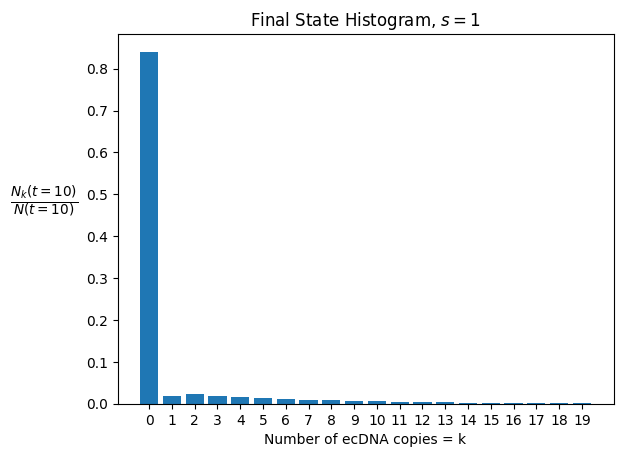

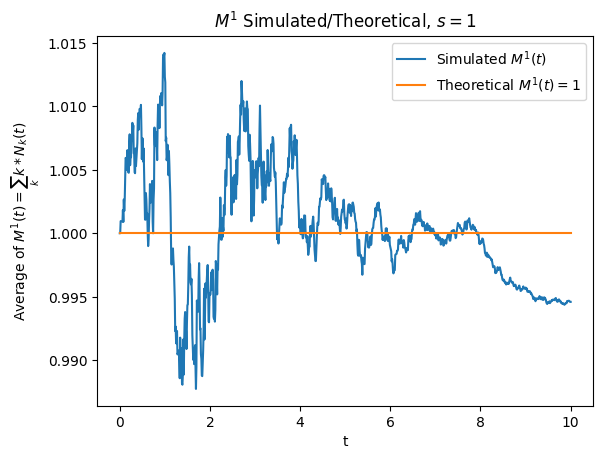

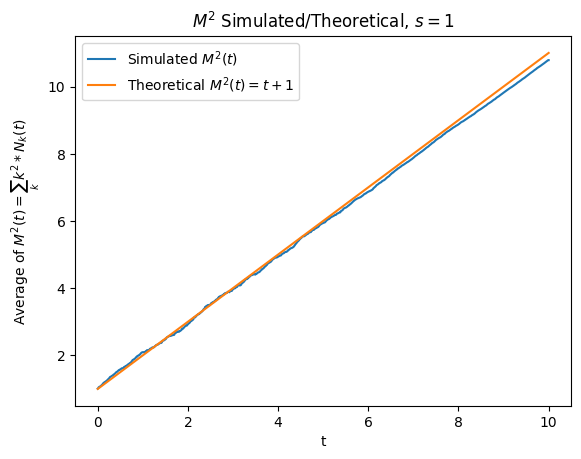

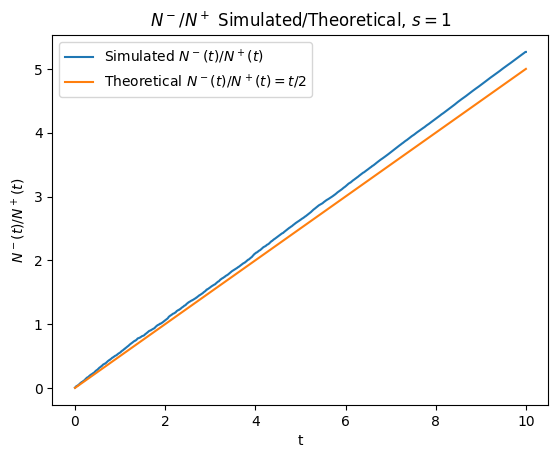

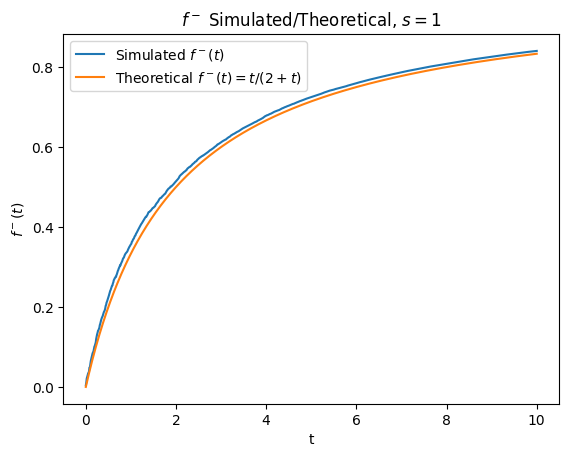

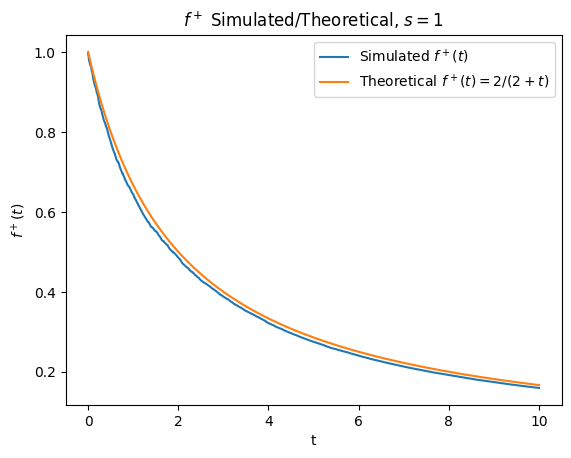

In [19]:
#Creating arrays to plot
#x-axis vectors: time and ecDNA states
kVals1 = np.arange(0, 20, 1)  #Creates vectors of integers 0-19 (first twenty states) to plot
times = np.arange(0, 10.01, 0.01)  #Array for time data (bins: 0,0.01,0.02,0.03 ... 9.98,9.99,10.00)

#y-axis vectors: N0,N, Particle count in final state
N0 = AvgSystem[1:, 0]
N = np.sum(AvgSystem, axis=1)[1:]
Nplus = N - N0  #Calculates Mean N+ Value from N+ + N- = N (where N- = N0)
finalStates = AvgSystem[-1, :20]  #Obtains average number of cells in each of the first 20 states
finalStatesNormalised = finalStates / N[-1]

#Theoretical Values to plot alongside simulated values
theoreticalM1 = np.ones(1001)  #Creates an array to plot with the theoretical M1 value (M2 = 1)
theoreticalM2 = times + 1  #Creates an array to plot with the theoretical M2 value (M2 = t+1)
theoreticalNratio = times / 2  #Creates an array of data for the theoretical value of N+/N- = t/2
theoreticalfminus = times / (2 + times)  #Creates an array of data for the theoretical value of f- = t/(2+t)
theoreticalfplus = 2 / (2 + times)  #Creates an array of data for the theoretical value of f+ = 2/(2+t)

#End State Histogram Plot
plt.title(r'Final State Histogram, $s=1$')
plt.bar(kVals1, finalStatesNormalised)
plt.xticks(np.arange(0, 20, 1))
plt.xlabel('Number of ecDNA copies = k')
plt.ylabel(r'$\frac{N_k(t=10)}{N(t=10)}$', rotation=0, fontsize=14, labelpad=30)
plt.show()

#1st moment plot
plt.title(r'$M^1$ Simulated/Theoretical, $s=1$')
plt.plot(times, moment1, label=r'Simulated $M^1(t)$')  #Plotting time (x-axis) against moment1 (y-axis)
plt.plot(times, theoreticalM1,
         label=r'Theoretical $M^1(t) = 1$')  #Plotting time (x-axis) against theoreticalM1 (y-axis) on same graph
plt.xlabel('t')
plt.ylabel(r'Average of $M^{1}(t) = \sum_k k*N_k(t)$')
plt.legend()
plt.show()  #Displays Plot

#second moment plot
plt.title(r'$M^2$ Simulated/Theoretical, $s=1$')
plt.plot(times, moment2, label=r'Simulated $M^2(t)$')  #Plotting time (x-axis) against moment2 (y-axis)
plt.plot(times, theoreticalM2,
         label=r'Theoretical $M^2(t) = t + 1$')  #Plotting time (x-axis) against theoreticalM2 (y-axis) on same graph
plt.legend()
plt.xlabel('t')
plt.ylabel(r'Average of $M^2(t) = \sum_k k^2*N_k(t)$')
plt.show()  #Displays Plot

#N- / N+ plot
plt.title(r'$N^-/N^+$ Simulated/Theoretical, $s=1$')
plt.plot(times, N0 / Nplus, label=r'Simulated $N^-(t) / N^+ (t)$')  #Plotting time (x-axis) against N-/N+ (y-axis)
plt.plot(times, theoreticalNratio,
         label=r'Theoretical $N^-(t) / N^+(t) = t / 2$')  #Plotting time (x-axis) against theoretical N-/N+ (y-axis) on same graph
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$N^-(t) / N^+ (t)$')
plt.show()  #Displays Plot

#f- plot
plt.title(r'$f^-$ Simulated/Theoretical, $s=1$')
plt.plot(times, N0 / N, label=r'Simulated $f^-(t)$')  #Plotting time (x-axis) against N-/N (y-axis)
plt.plot(times, theoreticalfminus,
         label=r'Theoretical $f^-(t) = t/(2+t)$')  #Plotting time (x-axis) against theoretical f- (y-axis) on same graph
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$f^-(t)$')
plt.show()  #Displays Plot

#f+ plot
plt.title(r'$f^+$ Simulated/Theoretical, $s=1$')
plt.plot(times, Nplus / N, label=r'Simulated $f^+(t)$')  #Plotting time (x-axis) against N+/N (y-axis)
plt.plot(times, theoreticalfplus,
         label=r'Theoretical $f^+(t) = 2/(2+t)$')  #Plotting time (x-axis) against theoretical f+ (y-axis) on same graph
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$f^+(t)$')
plt.show()  #Displays Plot

In [20]:
#s=2 simulation:
#s=1 Simulation
newBinnedData = np.zeros((100, 802,
                          200))  #Creates large data structure capable of holding the output of 100 iterations of the gillespie algorithm with s=2
for i in range(100):
    if i % 10 == 0:
        print('Simulation: ', i)  #Visual check to reassure the user that the code is running
    newBinnedData[i] = padData(GillespieSSA_2())
print('All Simulations Run')
AvgSystem2 = np.mean(newBinnedData,
                     axis=0)  #Calculates the 'average system' for each time t. i.e. takes the mean along the iteration axis of the data structure

Simulation:  0
Simulation:  10
Simulation:  20
Simulation:  30
Simulation:  40
Simulation:  50
Simulation:  60
Simulation:  70
Simulation:  80
Simulation:  90
All Simulations Run


Calculating Moments


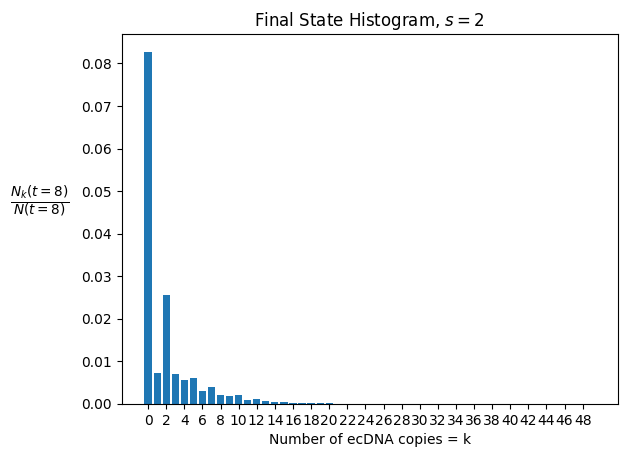

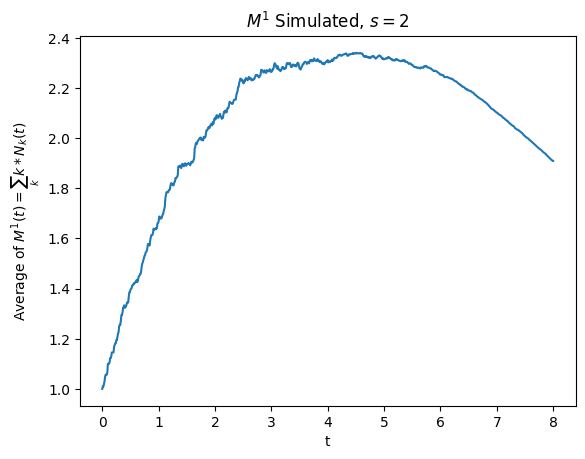

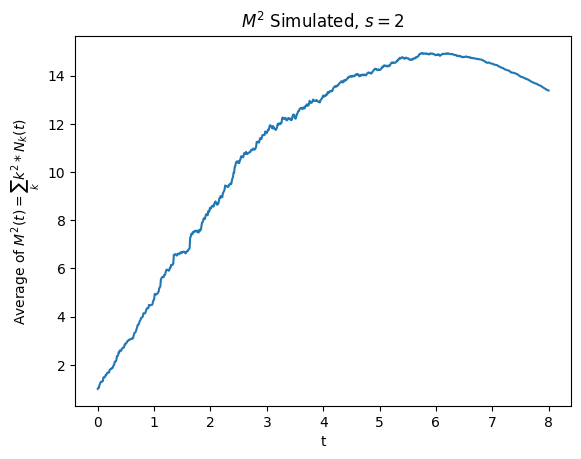

In [21]:
#Creating arrays to plot
#x-axis vectors: time and ecDNA states
kVals2 = np.arange(0, 50, 1)  #Creates vectors of integers 0-49 (first fifty states) to plot
times2 = np.arange(0, 8.01, 0.01)  #Array for time data (bins: 0,0.01,0.02,0.03 ... 7.98,7.99,8.00)

#y-axis vectors: M1,M2, Particle count in final state
finalStates2 = AvgSystem2[-1, :50]  #Obtains average number of cells in each of the first 20 states
finalStatesNormalised2 = finalStates2 / N[-1]
print('Calculating Moments')
s2moment1, s2moment2 = getMomentTimeSeries(AvgSystem2)

#Plots
#End State Histogram Plot
plt.title(r'Final State Histogram, $s=2$')
plt.bar(kVals2, finalStatesNormalised2)
plt.xticks(np.arange(0, 50, 2))
plt.xlabel('Number of ecDNA copies = k')
plt.ylabel(r'$\frac{N_k(t=8)}{N(t=8)}$', rotation=0, fontsize=14, labelpad=30)
plt.show()

#1st moment plot
plt.title(r'$M^1$ Simulated, $s=2$')
plt.plot(times, moment1, label=r'Simulated $M^1(t)$')  #Plotting time (x-axis) against moment1 (y-axis)
plt.xlabel('t')
plt.ylabel(r'Average of $M^{1}(t) = \sum_k k*N_k(t)$')
plt.show()  #Displays Plot

#second moment plot
plt.title(r'$M^2$ Simulated, $s=2$')
plt.plot(times, moment2, label=r'Simulated $M^2(t)$')  #Plotting time (x-axis) against moment2 (y-axis)
plt.xlabel('t')
plt.ylabel(r'Average of $M^2(t) = \sum_k k^2*N_k(t)$')
plt.show()  #Displays Plot